### Introduction

Cette section consiste à étudier l'algorithme des Random Fourier Features (RFF). C'est une méthode qui s'apparente à du boosting. Dans la suite, nous allons visualiser les frontières de décision du RFF lors des premières itérations afin de voir comment se comporte l'algorithme. Ensuite, nous allons le comparer à d'autres méthodes de boosting comme du XGBoost et du LGBM.

Lorsque ce n'est pas spécifié, les hyperparamètres du RFF ont pour valeur: $\gamma = 1$ et $\alpha = 1$.

### Importation des packages

In [ ]:
import numpy as np 
import pandas as pd
import time
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scripts.rff import *
from scripts.prepdata import data_recovery
from scripts.cross_validation import cross_validation
from scripts.convert_to_latex import *

### Frontière de décision du RFF sur un dataset 2D

Pour illuster la frontière de décission du RFF, nous allons apprendre notre algorithme sur les données "make_moons" de scikit-learn. Nous allons prendre T le nombre d'itération égal à 3.

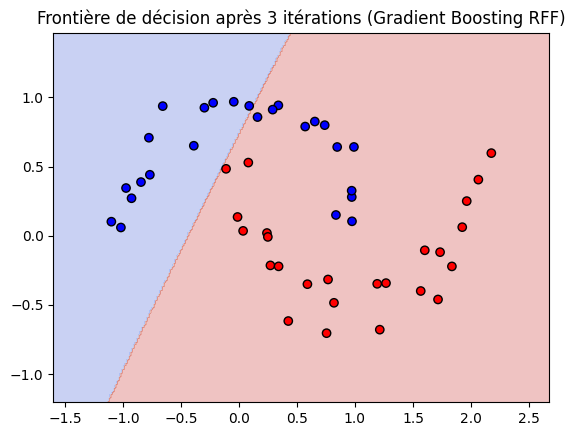

In [2]:
# Jeu de données simple
X, y = make_moons(n_samples=50, noise=0.1, random_state=0)
y = 2 * y - 1  # {-1, +1}

model = GradientBoostingRFF(T=3, gamma=0.5, lambda_reg=1.0, verbose=False)
model.fit(X, y)

# Visualisation des frontières
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
Z = model._H(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, np.sign(Z), alpha=0.3, cmap='coolwarm')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
plt.title("Frontière de décision après 3 itérations (Gradient Boosting RFF)")

# Sauvegarde du graphique
plt.savefig("images/rff_decision_boundary.png", dpi=300, bbox_inches='tight')

plt.show()

### Comparaison des frontières de décision du RFF avec celles du XGBoost et du SVM

Cette fois-ci, nous allons comparer le frontière de décision du RFF à celles du XGBoost et du SVM. Le nombre d'itération T=20. Nous allons visualiser les frontières sur le dataset "make_moons" de scikit_learn.

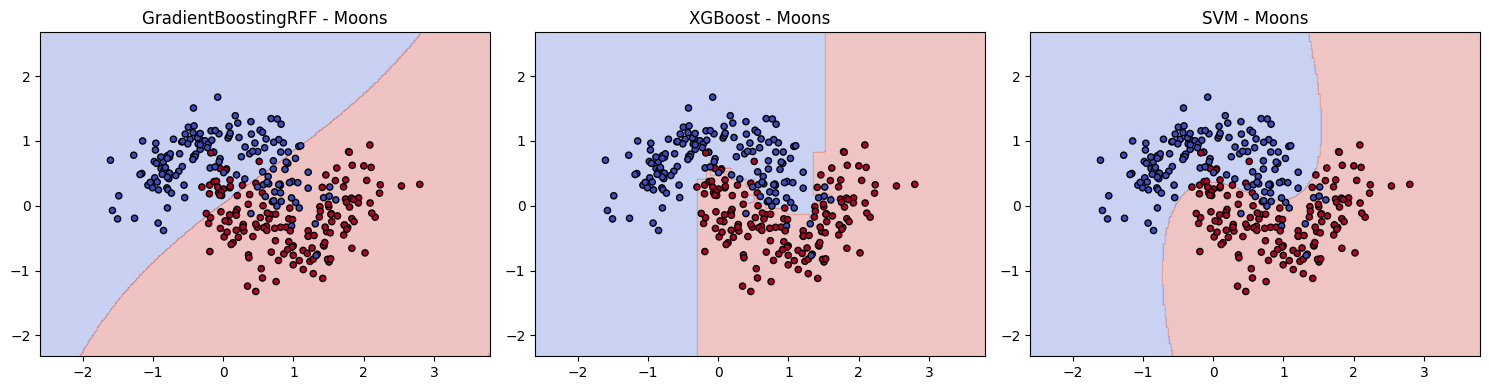

In [3]:
models = ['GradientBoostingRFF', 'XGBoost', 'SVM']

X, y = make_moons(n_samples=300, noise=0.3, random_state=0)
y = 2*y - 1
name = "Moons"
model_rff = GradientBoostingRFF(T=20, gamma=1.0, lambda_reg=1.0)
model_rff.fit(X, y)
xgb = XGBClassifier(n_estimators=50, max_depth=3)
xgb.fit(X, (y+1)//2)
svm = SVC(kernel='rbf', gamma='auto')
svm.fit(X, (y+1)//2)

# Visualisation des frontières
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                        np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Préparer la figure
plt.figure(figsize=(15, 4))
for i, clf in enumerate([model_rff, xgb, svm]):
    plt.subplot(1, 3, i+1)
    if i == 0:
        Z = clf.predict(grid)
    else:
        Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(f"{models[i]} - {name}")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
plt.tight_layout()

# Sauvegarde du graphique
plt.savefig("images/gradientboosting_decision_boundary.png", dpi=300, bbox_inches='tight')

plt.show()


### Comparaison du RFF au XGBoost et au LGBM

L'XGBoost et le LGBM sont des modèles basés sur le calcul du gradient. L'idée dans cette partie est de comparer ces modèles aux RFF en terme de performance et en terme de temps d'exécutions.

T le nombre d'itérations prend ses valeurs dans la liste [1, 5, 10, 20, 50].

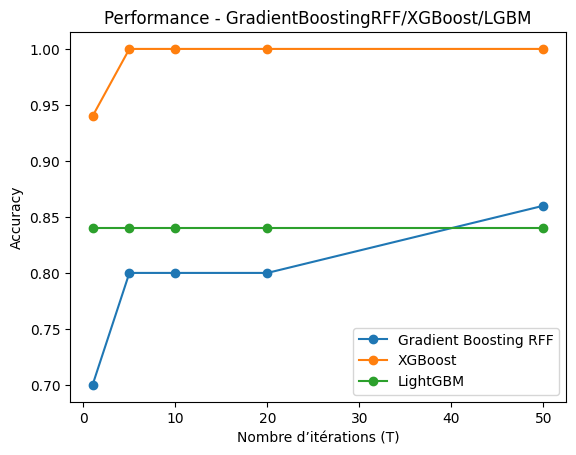

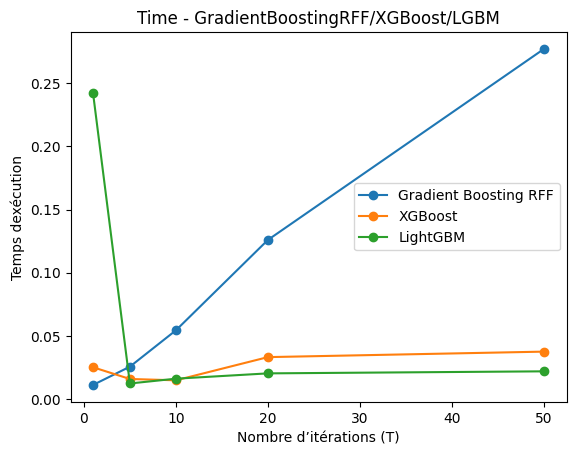

In [4]:
# Jeu de données simple
X, y = make_moons(n_samples=50, noise=0.1, random_state=0)
y = 2 * y - 1  # {-1, +1}

#Model Fit
T_values = [1, 5, 10, 20, 50]
acc_rff, acc_xgb, acc_lgb = [], [], []
time_rff, time_xgb, time_lgb = [], [], []

for T in T_values:
    start = time.time()
    model_rff = GradientBoostingRFF(T=T, gamma=1.0, lambda_reg=1.0)
    model_rff.fit(X, y)
    acc_rff.append((model_rff.predict(X) == y).mean())
    time_rff.append(time.time() - start)

    start = time.time()
    xgb = XGBClassifier(n_estimators=T)
    xgb.fit(X, (y+1)//2)
    acc_xgb.append(xgb.score(X, (y+1)//2))
    time_xgb.append(time.time() - start)

    start = time.time()
    lgb = LGBMClassifier(n_estimators=T, verbosity = -1)
    lgb.fit(X, (y+1)//2)
    acc_lgb.append(lgb.score(X, (y+1)//2))
    time_lgb.append(time.time() - start)

# Graphique comparatif
plt.figure()
plt.plot(T_values, acc_rff, '-o', label='Gradient Boosting RFF')
plt.plot(T_values, acc_xgb, '-o', label='XGBoost')
plt.plot(T_values, acc_lgb, '-o', label='LightGBM')
plt.xlabel('Nombre d’itérations (T)')
plt.ylabel('Accuracy')
plt.title("Performance - GradientBoostingRFF/XGBoost/LGBM")
plt.legend()

# Sauvegarde du graphique
plt.savefig("images/performance_rff.png", dpi=300, bbox_inches='tight')
plt.show()

# Graphique temps d'exécution
plt.figure()
plt.plot(T_values, time_rff, '-o', label='Gradient Boosting RFF')
plt.plot(T_values, time_xgb, '-o', label='XGBoost')
plt.plot(T_values, time_lgb, '-o', label='LightGBM')
plt.xlabel('Nombre d’itérations (T)')
plt.ylabel('Temps d''exécution')
plt.title("Time - GradientBoostingRFF/XGBoost/LGBM")
plt.legend()

# Sauvegarde du graphique
plt.savefig("images/time_rff.png", dpi=300, bbox_inches='tight')
plt.show()


### Application aux datasets équilibrés

Nous allons appliquer tout ce que nous avons fait jusqu'à maintenant à nos datasets équilibrés et modérément équilibrés. Comme paramètres pour la cross_validation, nous allons utiliser T le nombre d'itérations ([1, 5, 10, 20, 50]). En ce qui concerne, le GradientBoostRFF, nous allons également faire varier les paramètres $\gamma$ et $\lambda$ pour voir leur impact sur l'accuracy.

Nous avons $\gamma \in [0.1, 1]$ et $\lambda \in [0.1, 1]$.

In [5]:
grid = {
    "T": [1, 5, 10, 20, 50]
}

### Récupération des données

In [6]:
datasets_list = ['autompg', 'australian', 'balance', 'bupa', 'german', 'iono', 'pima', 'spambase', 'splice', 'vehicle', 'wdbc']

### Création du tableau des résutats

In [7]:
results_df = pd.DataFrame(index = datasets_list)

### 1.GradientBoostingRFF

In [ ]:
grid = {
    "T": [1, 5, 10, 20, 50]
}
gamma_values = [0.1, 1]
lambda_values = [0.1, 1]
for gamma in gamma_values:
    for lam in lambda_values:
        rff_grid = {
            "T": [1, 5, 10, 20, 50],
            "gamma": [gamma],
            "lambda_reg": [lam]
        }
        rff_list = []
        col_name = f"rff({gamma:.1f},{lam:.1f})"
        for dataset_name in datasets_list:
            dataset = data_recovery(dataset_name)
            x,y = dataset
            rff_list.append(cross_validation(x, 2*y-1, rff_grid, make_gradient_boosting_rff))
        results_df[col_name] = rff_list


### 2.XGBoost

In [9]:

xgboost_list = []
for dataset_name in datasets_list:
    dataset = data_recovery(dataset_name)
    x,y = dataset
    xgboost_list.append(cross_validation(x, y, grid, make_xgboost))
results_df["xgboost"] = xgboost_list

### 3.LGBM

In [10]:

lgbm_list = []
for dataset_name in datasets_list:
    dataset = data_recovery(dataset_name)
    x,y = dataset
    lgbm_list.append(cross_validation(x, y, grid, make_lgbm))
results_df["lgbm"] = lgbm_list

### Conversion du tableau de résultat en tableau latex

In [18]:
results_df.index.name = "Dataset"
results_df = results_df.reset_index()
results_df_latex = results_to_latex(results_df, caption="Accuracy -- GradientBoosting model comparison")
remove_pdf_if_exists("docs/gradientboosting_performance_results.pdf")
inject_table_in_template(results_df_latex, output_pdf="docs/gradientboosting_performance_results.pdf")

✅ Fichier supprimé : docs/gradientboosting_performance_results.pdf
✅ Compilation réussie → docs/gradientboosting_performance_results.pdf
